In [ ]:
%%html
<style>
table {float:left}
</style>

## Data analysis:

### Train set

| Label name | | Number of images |
| - | | - | 
| hyundai | | 302 | 
| lexus | | 301 | 
| mazda | | 317 | 
| mercedes | | 342 | 
| opel | | 301 | 
| skoda | | 314 | 
| toyota | | 306 | 
| volkswagen | | 330 | 

### Test set
| Label name | | Number of images |
| - | | - | 
| hyundai | | 50 | 
| lexus | | 50 | 
| mazda | | 50 | 
| mercedes | | 50 | 
| opel | | 50 | 
| skoda | | 50 | 
| toyota | | 50 | 
| volkswagen | | 50 | 

In [ ]:
%matplotlib inline

### Imports

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, ToPILImage
from torchvision.transforms.functional import to_grayscale, to_tensor, rotate, hflip
import matplotlib.pyplot as plt

import os
import random
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from sklearn.metrics import classification_report, confusion_matrix

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import seaborn as sn
import numpy as np

import io
from PIL import Image

### Useful functions to retrive the data

In [ ]:
# create a annotations_file.csv (index -> img (name), label (int))

def getLabelList(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        # print(len(os.listdir(new_path)))
        for img in [ name for name in os.listdir(new_path) ]:
            ret[index] = [img, label]
            index += 1
    
    return pd.Series(ret)

In [ ]:
# create the pool of images (with a series that contains all the images, more deeply: index -> abs path, label (int), class (string))

def getImgPool(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        # cnt = 0
        for img in [ name for name in os.listdir(new_path) ]:
            abs_path = new_path + '/' + img
            ret[index] = [abs_path, label, d]
            index += 1
            # cnt += 1
        # print(f"Label: {d} - Number: {cnt}")
    
    return pd.Series(ret)

### Defining the custom dataset (structure that holds the data)

In [ ]:
# wrong_images_path = []
import traceback

class CustomImageDataset(Dataset):
    def __init__(self, path_labels, transform=None, target_transform=None, use_aug=True):
        self.img_labels = getLabelList(path_labels)
        self.images = getImgPool(path_labels)
        self.transform = transform
        self.target_transform = target_transform
        self.use_aug = use_aug

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try: 
            image = read_image(self.images.loc[idx][0])
        except Exception:
            print('Found error at {} {}'.format(self.images.loc[idx][0], idx))
        #     wrong_images_path.append(self.images.loc[img_name][0])
            #return torch.zeros((1, 600, 600)), -1
        # image = read_image(self.images.loc[img_name][0])
        if image.shape[0] >= 3: #apply grayscale to colored img
            image = to_tensor(to_grayscale(ToPILImage()(image), num_output_channels=1))
        else: #we have a greyscaled image, move it into tensor 
            image = to_tensor(ToPILImage()(image))
            
        image = Resize((300, 300))(image)
        #data augmentation
        if self.use_aug:
            fr = random.choices([0,1],[0.2,0.8])[0]
            if fr == 1: 
                angle = torch.randint(40, size=(1,)).item() - 20
                #print (f'Rotate: {angle}')
                image = rotate(image, angle)

            fr = random.choices([0,1],[0.5,0.5])[0]
            if fr == 1: 
                image = hflip(image)
        
        #image = image.permute(1,2,0) #made to be shown on matplotlib
        label = self.img_labels.loc[idx][1]
        #if self.transform:
        #    image = self.transform(image)
        #if self.target_transform:
        #    label = self.target_transform(label)
        
        return image, label

### Creating the 2 dataset and testing

In [ ]:
train_path = 'data/car_brand_logos/Train/'
test_path = 'data/car_brand_logos/Test/'

SAVE_PATH = 'trained/auto_brand_hflip_3e2.pth'
RUNS_PATH = 'runs/car_brands_hflip_3e2'

In [ ]:
# train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), num_of_channels=3)
# test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), num_of_channels=3)

train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), target_transform=ToTensor())

test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), target_transform=ToTensor(), use_aug=False)

print (f'train dataset: {train_data.__len__()}')
print (f'test dataset: {test_data.__len__()}')

train dataset: 2512
test dataset: 400


In [ ]:
# for i in range(train_data.__len__()):
#     img, label = train_data[i]

# for i in range(test_data.__len__()):
#     img, label = test_data[i]
    
    
# wrong_images_path

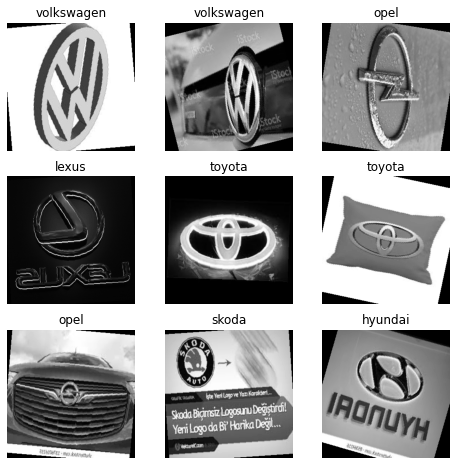

In [ ]:
#testing dataset if images are loaded

only_dirs = [ name for name in os.listdir(train_path) if 
                 os.path.isdir(os.path.join(train_path, name)) ]

diz = {}
nocl=0 #num of classes
for d in only_dirs:
    diz[nocl] = d
    nocl+=1

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item() 
    img, label = train_data[sample_idx]
    # print (img.shape, img.dtype, label)
    figure.add_subplot(rows, cols, i)
    plt.title(diz[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
    # plt.imshow(img.squeeze())
plt.show()

In [ ]:
# img, label = train_data[300]

# print(img.shape)

# plt.imshow(img.squeeze(), cmap='gray')

### creating dataloader (who iterate on data, create batches and shuffles it)


Feature batch shape: torch.Size([8, 1, 300, 300])
Labels batch shape: torch.Size([8])


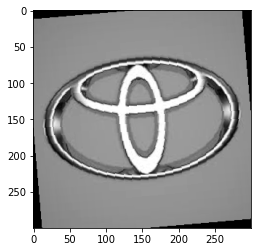

Label: toyota


In [ ]:
train_dl = DataLoader(train_data, batch_size=8, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_data, batch_size=8, shuffle=True)

#dataloader test (ask a batch or a sample)
images, labels = next(iter(train_dl)) #picking a batch
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
img = images[0].permute(1,2,0) #picking the first img and label of the batch
label = labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f"Label: {diz[label.item()]}")

In [ ]:
labels

tensor([6, 5, 1, 4, 2, 6, 6, 6])

In [ ]:
# os.rename('./data/car_brand_logos/Train/mercedes/r6.JPG', './data/car_brand_logos/Train/mercedes/r6.jpg')
# image = read_image('./data/car_brand_logos/Train/volkswagen/vosvos-volkswagen-logo-patches-arma-pec-kot-yamasi__1548797389090801.jpg')
# image = image.permute(1,2,0)
# plt.imshow(image, cmap='gray')
# plt.show()

### Defining the neural network

In [ ]:
print("GPU compute available: ", torch.cuda.is_available())


GPU compute available:  True


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        #conv1: 1 input image channel (image channel, 1 gray, 3 rgb), 6 output channels (depth [K]), 5x5 square convolution kernel, DEFAULT: stride = 1,1, padding = 0
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)        
        self.fc_layer1 = nn.Linear(16 * 72 * 72, 120)        
        self.fc_layer2 = nn.Linear(120, 84)
        self.fc_layer3 = nn.Linear(84, nocl) # nocl is the num of classes

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.pool(F.relu(self.conv1(x)))
        #print ('conv1', x.shape)
        # If the size is a square, you can specify with a single number
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        #print ('flatten', x.shape)
        x = F.relu(self.fc_layer1(x))
        x = F.relu(self.fc_layer2(x))
        x = self.fc_layer3(x)
        return x

In [ ]:
net = Net()
net.to(device)

Using cache found in C:\Users\eliad/.cache\torch\hub\pytorch_vision_v0.10.0


In [ ]:
#test
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

62
torch.Size([64, 3, 7, 7])


In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# use gradient descent
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
best_net = Net()
best_net.to(device)

### Tensorboard setup

start tensorboard: `tensorboard --logdir=Users\eliad\Tesi\ProgettoTesi\runs\car_brands_1`

In [ ]:
# writer = SummaryWriter(RUNS_PATH)

In [ ]:
# # get some random training images
# dataiter = iter(train_dl)
# images, labels = dataiter.next()

# #visualizing and adding images into tb
# for idx in range(4):    
#     img = images[idx]
#     plt.imshow(img.squeeze(), cmap='gray')
#     plt.show()
#     print (img.shape, img.dtype)
#     writer.add_image(f"car_brands_images_{idx+1}", img)

In [ ]:
# writer.close()

### Adding the graph of the network into Tensorboard

In [ ]:
# writer.add_graph(net, images.to(device))
# writer.close()

### Adding the projector 

In [ ]:
# tmp_dl = DataLoader(train_data, batch_size=100, shuffle=True)
# images, labels = next(iter(tmp_dl))

# # get the class labels for each image
# class_labels = [diz[lab.item()] for lab in labels]


# images = Resize((28, 28))(images)

# features = images.view(-1, 28 * 28)
# writer.add_embedding(features,
#                     metadata=class_labels,
#                     label_img=images)
# writer.close()

### Confusion matrix during training

In [ ]:
def createConfusionMatrix(loader, netw):
    y_pred = [] # save predction
    y_true = [] # save ground truth

    # iterate over data
    for inputs, labels in loader:
        output = netw(inputs.to(device))  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # save prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # save ground truth

    # constant for classes
    classes = diz.values()

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index=[i for i in classes],
                         columns=[i for i in classes])
    plt.figure(figsize=(7, 7), dpi=125)
    sn.heatmap(df_cm, annot=True)
    
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg')
    buf.seek(0)
    im = Image.open(buf)
    im = ToTensor()(im)
    return im

### Training the network

In [ ]:
print(next(net.parameters()).device)

cuda:0


In [ ]:
best_test_loss = 10000
for epoch in range(5):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_dl):
        # get the inputs; data is a list of [inputsdeviceels]
        inputs, labels = data
        # inputs, labels = data[0].to(device), data[1].to(device)
        #print (inputs.shape)
        #inputs = inputs.permute(0, 3, 1, 2) # to get a shape of [64, 1, 600, 600]
        inputs = inputs.to(device)
        labels = labels.to(device)
        #print (inputs.device, label.device)

        # inputs = inputs.view(64, -1) #1° param specifico io, altri calcola lui (-1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print (outputs.device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        skip = 50
        if i > 0  and i % 50 == 0:    # print every 360 images (8 images per batch, 45 loops)
            print(f'[{epoch + 1}, {i}/{len(train_dl)}] loss: {(running_loss/skip):.3f}')
            # ...log the running loss
            # writer.add_scalar('training loss',
            #            running_loss / skip,
            #            epoch * len(train_dl) + i)
            running_loss = 0.0

    #end of an epoch, calculate loss on test set (since it's small and there's no need to split)
    with torch.no_grad():
        test_loss = 0
        test_batch = 0
        net.eval()
        for _, data in enumerate(test_dl):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            #inputs = inputs.permute(0, 3, 1, 2)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_batch += 1
        actual_test_loss = test_loss/test_batch
        print(f"[{epoch + 1}] test loss: {(actual_test_loss):.3f}")
        if actual_test_loss < best_test_loss:
            best_test_loss = actual_test_loss
            best_net.train()
            best_net = net
            best_net.eval()
        # writer.add_scalar('test loss',
        #                test_loss/test_batch,
        #                epoch+1)
        # confusion matrix (added from extra step)        
        # writer.add_image("confusion_matrix2", createConfusionMatrix(test_dl, net), global_step=epoch)
        # writer.close()
        

print('Finished Training')

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[8, 1, 300, 300] to have 3 channels, but got 1 channels instead

In [ ]:
#saving the trained model
torch.save(net.state_dict(), SAVE_PATH)

### Testing the network on test set

In [ ]:
loaded = Net()
# loaded.load_state_dict(torch.load("trained/auto_brand_no_flip_16e.pth"))
loaded.load_state_dict(torch.load(SAVE_PATH))

In [ ]:
loaded.to(device)
loaded.eval()

In [ ]:
images, labels = next(iter(test_dl)) #picking a batch

n_imgs = len(images)
img = images.to(device)
label = labels.to(device)

preds = net(img)
_, best_pred = torch.max(preds.data, 1)

fig, axs = plt.subplots(figsize=(25,4), nrows=1, ncols=n_imgs)

for i in range(n_imgs):
    axs[i].imshow(img[i].permute(1,2,0).cpu(), cmap='gray')
    axs[i].set_title('T: {}\nP: {}'.format(diz[label[i].item()], diz[best_pred[i].item()]))

In [ ]:
# # 1. gets the probability predictions in a test_size x num_classes Tensor
# # 2. gets the preds in a test_size Tensor
# class_probs = []
# class_label = []
# with torch.no_grad():
#     for data in test_dl:
#         images, labels = data
#         images = images.to(device)
#         labels = labels.to(device)
#         output = net(images)
#         class_probs_batch = [F.softmax(el, dim=0) for el in output]

#         class_probs.append(class_probs_batch)
#         class_label.append(labels)

# test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
# test_label = torch.cat(class_label)

# # helper function
# def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
#     '''
#     Takes in a "class_index" from 0 to 9 and plots the corresponding
#     precision-recall curve
#     '''
#     tensorboard_truth = test_label == class_index
#     tensorboard_probs = test_probs[:, class_index]

#     writer.add_pr_curve(diz[class_index],
#                         tensorboard_truth,
#                         tensorboard_probs,
#                         global_step=global_step)
#     writer.close()

# # plot all the pr curves
# for i in range(len(diz.values())):
#    add_pr_curve_tensorboard(i, test_probs, test_label)

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in diz}
total_pred = {classname: 0 for classname in diz}

y_true = []
y_pred = []

# again no gradients needed
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label.item()] += 1
            total_pred[label.item()] += 1
            y_true.append(label.cpu())
            y_pred.append(prediction.cpu())

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {diz[classname]} is {accuracy:.1f} %')

In [ ]:
#stampa report classificazioni
print(classification_report(y_true, y_pred, target_names=diz.values()))

In [ ]:
fig, axs = plt.subplots(figsize=(20,12), nrows=1, ncols=2)
axs[0].imshow(createConfusionMatrix(test_dl, net).permute(1,2,0))
axs[0].set_title('Trained Net')
axs[1].imshow(createConfusionMatrix(test_dl, loaded).permute(1,2,0))
axs[1].set_title('Loaded Net')